In [76]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR

In [77]:
data = pd.read_csv('salary_data.csv')

In [78]:
data.head()

,Job Title,Company name,Location,Salary(INR),Rating,Revenue(Million USD),Company type
0,Data Analyst,Accenture,Mumbai,NaN,4.1,10000.0,Public
1,Data Analyst,Eclerx,Mumbai,268775.0,3.6,300.0,Public
2,Data Analyst,TTEC,Mumbai,276912.0,3.5,3500.0,Public
3,Data Analyst,Kroll,Mumbai,795089.0,3.7,3500.0,Private
4,Data Analyst,Mio Design Pvt. Ltd,Mumbai,7200000.0,NaN,NaN,NaN


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Job Title             494 non-null    object 
 1   Company name          494 non-null    object 
 2   Location              494 non-null    object 
 3   Salary(INR)           403 non-null    float64
 4   Rating                355 non-null    float64
 5   Revenue(Million USD)  184 non-null    float64
 6   Company type          355 non-null    object 
dtypes: float64(3), object(4)
memory usage: 27.1+ KB


In [80]:
## Company name is like a unique id, so we can drop it from our dataset
data.drop('Company name',axis =1,inplace =True)

In [81]:
## considering those value only which has our target variable as some real value:
data = data[data['Salary(INR)'].notnull()]
data.shape

(403, 6)

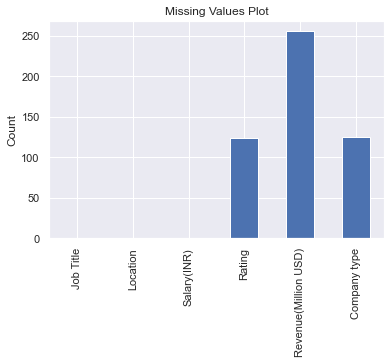

In [82]:
data.isna().sum().plot(kind ='bar')
plt.title('Missing Values Plot')
plt.ylabel('Count')
plt.show()

In [83]:
## Let makes my work little easy: Rename the column
dict = {'Salary(INR)': 'Salary', 'Revenue(Million USD)': 'Revenue'}
data.rename(columns =dict,inplace =True)
data.head()

,Job Title,Location,Salary,Rating,Revenue,Company type
1,Data Analyst,Mumbai,268775.0,3.6,300.0,Public
2,Data Analyst,Mumbai,276912.0,3.5,3500.0,Public
3,Data Analyst,Mumbai,795089.0,3.7,3500.0,Private
4,Data Analyst,Mumbai,7200000.0,NaN,NaN,NaN
5,Data Analyst,Mumbai,289116.0,4.0,10000.0,Private


In [84]:
data.describe()

,Salary,Rating,Revenue
count,4.030000e+02,279.000000,147.000000
mean,6.182250e+05,3.934409,6311.438776
std,5.059657e+05,0.529727,8988.442951
min,6.622100e+04,1.000000,1.000000
25%,4.000000e+05,3.700000,300.000000
50%,5.500000e+05,4.000000,7500.000000
75%,6.928200e+05,4.200000,10000.000000
max,7.200000e+06,5.000000,101000.000000


### Almost 65% of values of 'Revenue' feature is NULL, so to handle the missing values, let see its relation with other features

In [85]:
# Taking only not null values of Revenue feature
df = data[data['Revenue'].notnull()]

In [86]:
df.shape

(147, 6)

<AxesSubplot:>

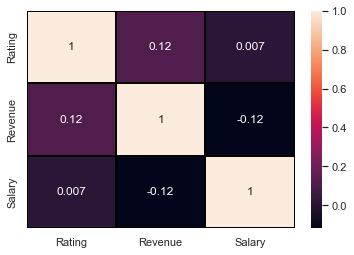

In [87]:
##  Checking Correlation matrix 

correlation = df[['Rating','Revenue','Salary']].corr()
sns.heatmap(correlation,linecolor='black',linewidth=2,annot =True)

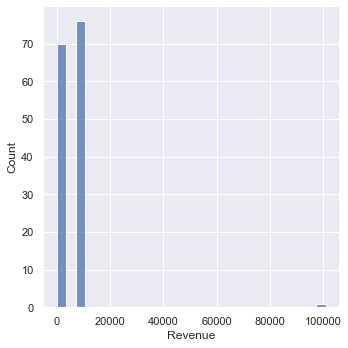

In [88]:
### Distribution plot of Revenue

sns.displot(df, x="Revenue")

In [89]:
## Checking out the unique real values in Revenue:

print('Number of Unique values:',df['Revenue'].nunique())
df['Revenue'].unique()

Number of Unique values: 11


array([3.00e+02, 3.50e+03, 1.00e+04, 7.50e+03, 1.00e+00, 7.50e+02,
       3.00e+00, 1.50e+01, 3.00e+01, 1.01e+05, 3.75e+01])

<AxesSubplot:xlabel='Salary', ylabel='Revenue'>

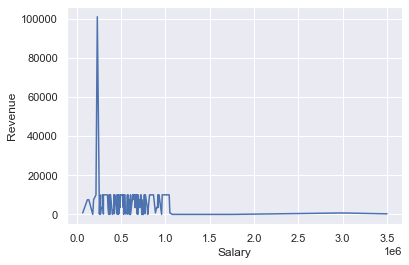

In [90]:
sns.set_theme(style='darkgrid')
sns.lineplot(x='Salary', y='Revenue',data=df, hue=None)

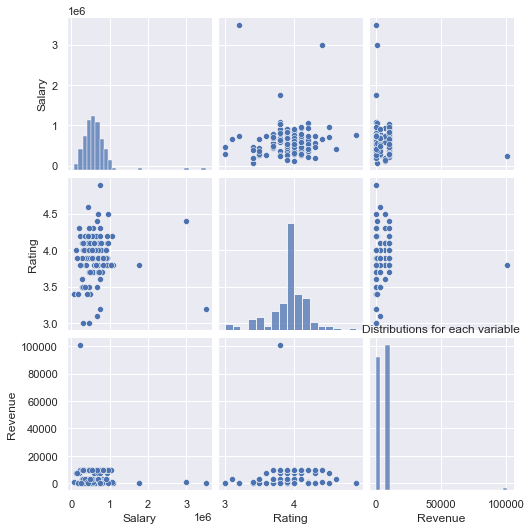

In [91]:
## plotting the scatter plot
sns.pairplot(data=df)
plt.title('Distributions for each variable')
plt.show()

#### Observation :
<li>It has been found that 'Revenue' has weak correlation with target variable </li>
<li> There are just 11 values of 'Revenue' feature, so imputing such a large number of values may produce the biased data </li>
<li> Rating and Revenue has a postive correlation, although it is a weak correlation</li>
<p>So, on the basis of above observations, droping the 'Revenue' may result in better model</p>


### Missing values imputation:

<p><b>We have two types of variables which have missing data : categrical variables and real-valued variables. To impute the missing value for real-valued features, missing techniques like Interpolation, Median and Mean can be used. To decide which one to use, we will follow the given approach: </b></p>
<li>Make the two copied of given dataset and  randomly choose 30% (just a random number) those rows of features which does not have null value</li>
<li> Store the indexes of the above chosen rows</li>
<li>Now try to impute the values of whole real-valued feature by the any of the above techniques for just one copy of dataset</li>
<li> Now compute the MSE (mean squared error) of imputed values and orignal dataset values  corresponding to the chosen rows in step 2 </li>
<li> Method which give the lowest MSE will be selected</li>

<p> For categorical variable, we will use the regression technique i.e. a given categorical variable will be taken as target class while other features will be taken as predictors and then apply regression method</p>


In [92]:
df = data[['Revenue','Rating']]
df = df.reset_index()

In [93]:
df.head()

,index,Revenue,Rating
0,1,300.0,3.6
1,2,3500.0,3.5
2,3,3500.0,3.7
3,4,NaN,NaN
4,5,10000.0,4.0


In [94]:
#  This function will create 2 copies of feature column, one out of which will used for imputation
def setting_up_data(feature):
    indexes = np.where(np.isnan(df[feature]) == False)[0]
    random.seed(42)
    indexes = indexes.tolist()
    indexes = random.sample(indexes, int(0.3*len(indexes)))
    df2_imputed = df.copy()
    df2_imputed.loc[indexes, feature] = np.NaN
    
    return indexes,df2_imputed

In [95]:
# This function will return feature values after imputation
def impute_values(feature,df2_imputed,strategy):
    
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    col_pm = df2_imputed[feature].values.reshape(-1, 1)
    imputed_col_pm = imp.fit_transform(col_pm)
    data_imputed = df2_imputed.copy()
    data_imputed.loc[:,feature] = imputed_col_pm
    
    return data_imputed

In [96]:
# Calculate the MSE of imputation values:
def MSE(feature, list):
    x1 = df.loc[list,feature]
    x2 = data_imputed.loc[list, feature]
    mse = mean_squared_error(x1, x2)
    return mse

In [97]:
columns = ['Rating']
methods = ['mean','median']
for method in methods:
    
    for column in columns:
        row,df2_imputed = setting_up_data(column)
        data_imputed = impute_values(column,df2_imputed,method)
        mse = MSE(column,row)
        print('The MSE for {} using {} as imputation technique is: {}'.format(column,method,mse))
    


The MSE for Rating using mean as imputation technique is: 0.40556912468700274
The MSE for Rating using median as imputation technique is: 0.412289156626506


In [98]:
# data  = impute_values('Revenue',data,'mean')
# As the mean give small MSE, so we will use 'mean' technique for imputation
data  = impute_values('Rating',data,'mean')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 1 to 493
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Job Title     403 non-null    object 
 1   Location      403 non-null    object 
 2   Salary        403 non-null    float64
 3   Rating        403 non-null    float64
 4   Revenue       147 non-null    float64
 5   Company type  278 non-null    object 
dtypes: float64(3), object(3)
memory usage: 22.0+ KB


In [99]:
# As decided above, we will drop 'Revenue' feature
data.drop('Revenue',axis =1,inplace =True)

In [100]:
data.head()

,Job Title,Location,Salary,Rating,Company type
1,Data Analyst,Mumbai,268775.0,3.600000,Public
2,Data Analyst,Mumbai,276912.0,3.500000,Public
3,Data Analyst,Mumbai,795089.0,3.700000,Private
4,Data Analyst,Mumbai,7200000.0,3.934409,NaN
5,Data Analyst,Mumbai,289116.0,4.000000,Private


In [101]:
from sklearn.linear_model import LinearRegression

In [102]:
def find_missing_values(data,feature):
    data.head()
    test = data[data[feature].isna()]
    train = data.dropna()
    # Preparing Data
    X_train = train.drop([feature], axis=1)
    y_train = train[feature]
    X_test = test.drop([feature], axis=1)
    # Getting ready a model to predict missing values
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    # Predictions
    y_pred = linear.predict(X_test)
    for i in range(len(y_pred)):
        if(y_pred[i]>=0.5):
            y_pred[i]=1
        else:
            y_pred[i]=0
    
    return y_pred 
    

In [103]:
dataset = data.copy()

In [104]:
dataset = data.copy()
# One hot encoding
dataset= pd.get_dummies(dataset,columns= ['Job Title','Location'])
dataset.replace(to_replace=["Public",'Private'], value=[1,0],inplace=True)
#Filling Weight
dataset.loc[dataset['Company type'].isnull(), 'Company type'] =  find_missing_values(dataset,'Company type')
data['Company type'] = dataset['Company type']
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 1 to 493
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Job Title     403 non-null    object 
 1   Location      403 non-null    object 
 2   Salary        403 non-null    float64
 3   Rating        403 non-null    float64
 4   Company type  403 non-null    float64
dtypes: float64(3), object(2)
memory usage: 18.9+ KB


In [105]:

data.head()

,Job Title,Location,Salary,Rating,Company type
1,Data Analyst,Mumbai,268775.0,3.600000,1.0
2,Data Analyst,Mumbai,276912.0,3.500000,1.0
3,Data Analyst,Mumbai,795089.0,3.700000,0.0
4,Data Analyst,Mumbai,7200000.0,3.934409,0.0
5,Data Analyst,Mumbai,289116.0,4.000000,0.0


In [106]:
ddd = data.copy()

In [107]:
data =ddd.copy()

### Visualization

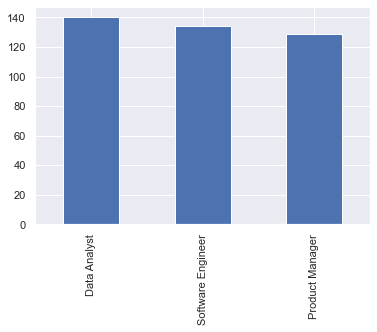

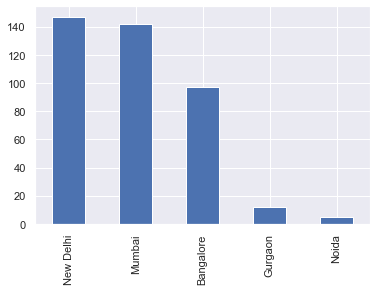

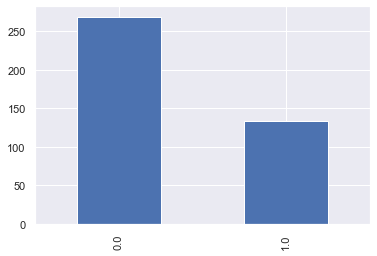

In [108]:
# fig, ax = plt.subplots(2,2,figsize=(12,12))
columns = ['Job Title', 'Location','Company type']
for column in columns:
#     or item in list(data[column].unique()):
    data[column].value_counts().plot(kind = 'bar')
    plt.show()
       

In [109]:
data['Location'].value_counts()

New Delhi    147
Mumbai       142
Bangalore     97
Gurgaon       12
Noida          5
Name: Location, dtype: int64

<li> There are decent number of sample instances of Mumbai, Bangalore and Delhi but very few for Noida and Gurgaon</li>
<li> There are comparable number of instances of all job roles</li>
<li> There are almost 140 instances of 'Public' and 260 instances of 'Private' company type </li>

In [110]:
data.shape

(403, 5)

In [111]:
## We can remove the values containing 'Gurgaon' and 'Noide' as location as these are very few
filter = (data['Location']=='Mumbai')| (data['Location']=='New Delhi')|(data['Location']=='Bangalore')
data = data.where(filter)
data.dropna(inplace =True)
data.shape

(386, 5)

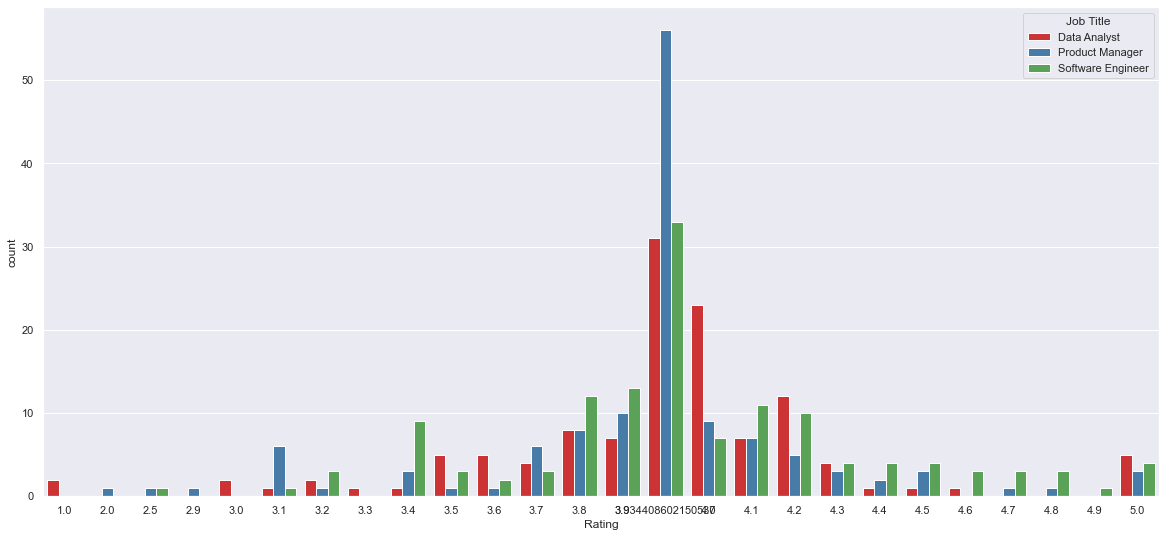

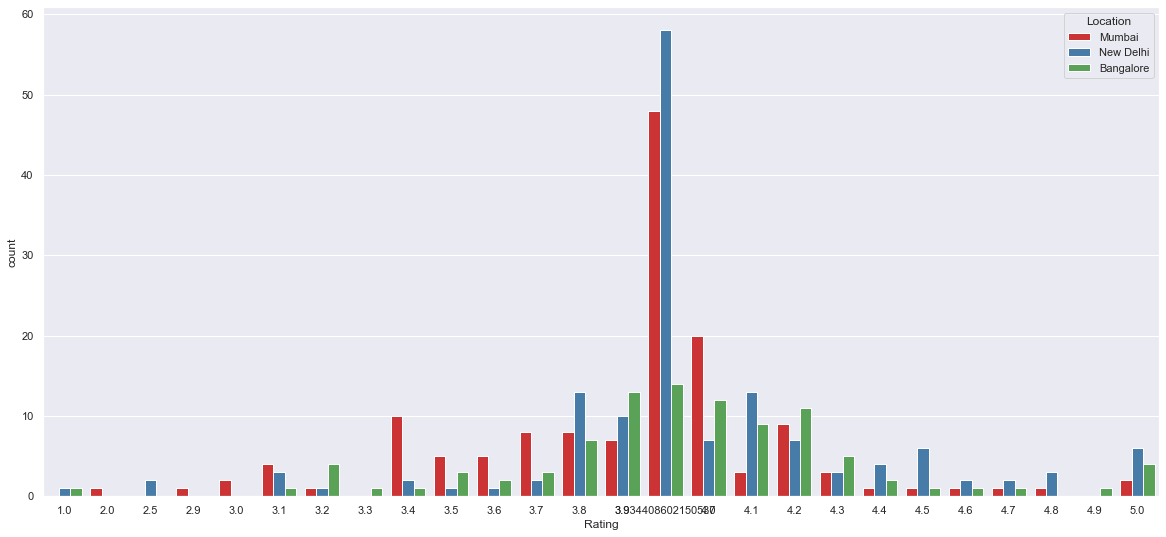

In [112]:
plt.figure(figsize = (20,9))
sns.countplot(x='Rating',hue='Job Title',data =data, palette='Set1')
plt.show()
plt.figure(figsize = (20,9))
sns.countplot(x='Rating',hue='Location',data =data, palette='Set1')
plt.show()

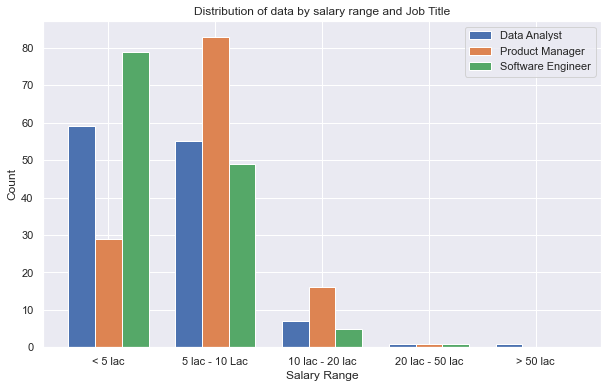

In [113]:
s_bins = [0,500000,1000000,2000000,5000000,10000000]
salary_bins = pd.cut(data['Salary'], bins=s_bins)
grouped_data = data.groupby([salary_bins, 'Job Title'])['Job Title'].count().reset_index(name='Count')
pivoted_data = grouped_data.pivot(index='Salary', columns='Job Title', values='Count')

# Get the list of salary ranges
salary_ranges = list(pivoted_data.index.astype(str))

# Set the width of each bar
bar_width = 1 / (len(pivoted_data.columns) + 1)

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each location and plot its bar chart
for i, loc in enumerate(pivoted_data.columns):
    counts = pivoted_data[loc]
    x_pos = [j + i * bar_width for j in range(len(salary_ranges))]
    ax.bar(x_pos, counts, width=bar_width, label=loc)

# Add labels and title
ax.set_xlabel('Salary Range')
ax.set_ylabel('Count')
ax.set_title('Distribution of data by salary range and Job Title')
ax.set_xticks([i + bar_width * (len(pivoted_data.columns) - 1) / 2 for i in range(len(salary_ranges))])

ranges_title = ['< 5 lac', '5 lac - 10 Lac', '10 lac - 20 lac', '20 lac - 50 lac', '> 50 lac']
ax.set_xticklabels(ranges_title)
ax.legend()
plt.show()

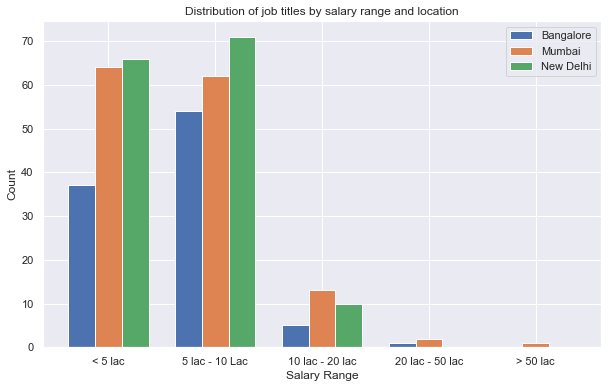

In [114]:
s_bins = [0,500000,1000000,2000000,5000000,10000000]
salary_bins = pd.cut(data['Salary'], bins=s_bins)
grouped_data = data.groupby([salary_bins, 'Location'])['Job Title'].count().reset_index(name='Count')
pivoted_data = grouped_data.pivot(index='Salary', columns='Location', values='Count')

# Get the list of salary ranges
salary_ranges = list(pivoted_data.index.astype(str))

# Set the width of each bar
bar_width = 1 / (len(pivoted_data.columns) + 1)

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each location and plot its bar chart
for i, loc in enumerate(pivoted_data.columns):
    counts = pivoted_data[loc]
    x_pos = [j + i * bar_width for j in range(len(salary_ranges))]
    ax.bar(x_pos, counts, width=bar_width, label=loc)

# Add labels and title
ax.set_xlabel('Salary Range')
ax.set_ylabel('Count')
ax.set_title('Distribution of job titles by salary range and location')
ax.set_xticks([i + bar_width * (len(pivoted_data.columns) - 1) / 2 for i in range(len(salary_ranges))])

ranges_title = ['< 5 lac', '5 lac - 10 Lac', '10 lac - 20 lac', '20 lac - 50 lac', '> 50 lac']
ax.set_xticklabels(ranges_title)
ax.legend()
plt.show()

### Box plots

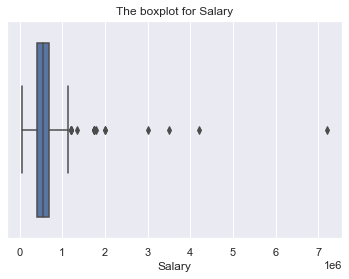

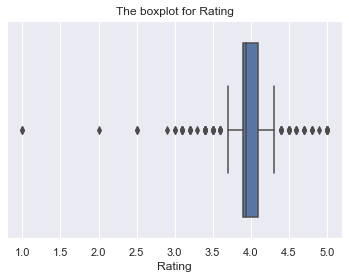

In [115]:
col = ['Salary','Rating']
for item in col:
    sns.boxplot(x=item,data =data)
    plt.title("The boxplot for {}".format(item))
    plt.show()

In [116]:
dt = data.copy()

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386 entries, 1 to 493
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Job Title     386 non-null    object 
 1   Location      386 non-null    object 
 2   Salary        386 non-null    float64
 3   Rating        386 non-null    float64
 4   Company type  386 non-null    float64
dtypes: float64(3), object(2)
memory usage: 18.1+ KB


In [118]:
filter = (data['Salary']<2000000) & (data['Rating']>2.4)
filter1 = data['Rating']<4.9
data = data.where(filter)
data = data.where(filter1)
data.dropna(inplace =True)
data.shape

(364, 5)

### Pre-Processing

In [119]:

st_x = StandardScaler()
data['Rating']= st_x.fit_transform(np.array(data['Rating']).reshape(-1,1))
data['Salary']= st_x.fit_transform(np.array(data['Salary']).reshape(-1,1))
data.head()

,Job Title,Location,Salary,Rating,Company type
1,Data Analyst,Mumbai,-1.125089,-1.005029,1.0
2,Data Analyst,Mumbai,-1.095172,-1.313940,1.0
3,Data Analyst,Mumbai,0.809966,-0.696118,0.0
5,Data Analyst,Mumbai,-1.050303,0.230616,0.0
6,Data Analyst,Mumbai,-0.295276,0.230616,1.0


<!-- Apply different techniques like cross=validation , k-fold
Apply Bagging, Boostrapping
Apply all rigression models:>
Check error on both training and testing data
grid search cv
hot encoding 
label encoding
With and without revenue
Outliers skipping 
Boostrap and boosting
Hyper parameter tuning
scaler.inverse_transform
What if scale of target variable is as such
-->

<!-- Hot and label encoding 
 scaler _inverse transform
streamlit
what is salary is not scaled
wha
-->

In [120]:
labeler = LabelEncoder()
strip_columns = ['Company type','Location','Job Title']
for item in strip_columns:
    data[item] = labeler.fit_transform(data[item])
data.head()

,Job Title,Location,Salary,Rating,Company type
1,0,1,-1.125089,-1.005029,1
2,0,1,-1.095172,-1.313940,1
3,0,1,0.809966,-0.696118,0
5,0,1,-1.050303,0.230616,0
6,0,1,-0.295276,0.230616,1


In [121]:
X = data.drop('Salary',axis =1)
Y= data["Salary"]

In [122]:
# Splitting in 70-30 ratio:
X_train ,X_test ,Y_train, Y_test =  train_test_split(X,Y,test_size=0.30,random_state=42,shuffle=True)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(254, 4) (110, 4) (254,) (110,)


In [123]:
simple_regression = linear_model.LinearRegression()
simple_regression.fit(X_train,Y_train)
Y_pred = simple_regression.predict(X_test)
print('Coefficients:', simple_regression.coef_)
print('Intercept:', simple_regression.intercept_)

Coefficients: [-0.17463632  0.05771285  0.04680343  0.15123274]
Intercept: 0.0655205665553232


In [124]:
mse =mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print('Mean squared error (MSE):  {:.2f}'.format(mse))
print('Root Mean squared error (RMSE): {:.2f}'.format(np.sqrt(mse)))


Mean squared error (MSE):  0.91
Root Mean squared error (RMSE): 0.95


In [125]:
def testing_metrics(X_test,Y_test,model):
    Y_pred = model.predict(X_test)
    mse =mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    
    print('Testing data Results\n')
    print('Mean squared error (MSE):  {:.2f}'.format(mse))
    print('Root Mean squared error (RMSE): {:.2f}'.format(np.sqrt(mse)))

    return Y_pred,np.sqrt(mse)

In [126]:
def training_metrics(Y_train,X_train,model):
    Y_predict_2 = model.predict(X_train)
    mse =mean_squared_error(Y_train, Y_predict_2)
    r2 = r2_score(Y_train, Y_predict_2)
    print('Training data Results\n')
    print('Mean squared error (MSE) :  {:.2f}'.format(mse))
    print('Root Mean squared error (RMSE): {:.2f}'.format(np.sqrt(mse)))

    return Y_predict_2, np.sqrt(mse)

In [127]:
def plot_errors(Y_pred,Y_predict_2,Y_test,Y_train,context):
    error  = 100*(Y_pred-Y_test)/Y_test
#     Prediction_df = pd.DataFrame({'Actual Test Values': Y_test.squeeze(), 'Predicted Test Values': Y_pred.squeeze(), '% Error': error.squeeze()})
    error_2 = 100*(Y_predict_2-Y_train)/Y_train
#     Prediction_df2 = pd.DataFrame({'Actual Train Values': Y_train.squeeze(), 'Predicted Train Values': Y_predict_2.squeeze(), '% Error': error_2.squeeze()})
    plt.figure(figsize=(12,8))
    plt.scatter(Y_predict_2, Y_predict_2 - Y_train,color = "green", s = 13,label = 'Train data')
    plt.scatter(Y_pred, Y_pred- Y_test,  color = "blue", s = 13,label = 'Test data' )
    plt.xlabel('Predictions')
    plt.ylabel('Residual Error')
    plt.title("Training and Testing errors for {} model".format(context))
    plt.legend(['Training error','Testing error'])
    plt.show()
    

### Results

Testing data Results

Mean squared error (MSE):  0.91
Root Mean squared error (RMSE): 0.95
Training data Results

Mean squared error (MSE) :  1.03
Root Mean squared error (RMSE): 1.02


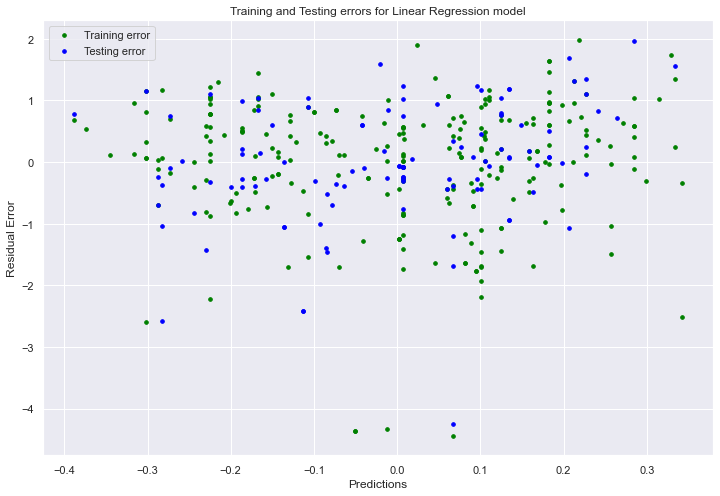

In [128]:
Y_pred,rmse_reg = testing_metrics(X_test,Y_test,simple_regression)
Y_predict_2 ,rmse_reg_train= training_metrics(Y_train,X_train,simple_regression)
plot_errors(Y_pred,Y_predict_2,Y_test,Y_train,'Linear Regression')

#### Above plot shows that residual error of training and testing data is comparably spread across 2 to -3 range
#### This also ensure that model is not overfitted

### Using KFold method 

In [129]:
#define cross-validation method to use
cv = KFold(n_splits=10, random_state=1, shuffle=True)

#build multiple linear regression model
model = LinearRegression()

#use k-fold CV to evaluate model
# create a KFold object with 5 splits 
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
scores = cross_val_score(model, X_train, Y_train,scoring='neg_mean_absolute_error',cv=folds)
#view mean squared  error
print(mean(absolute(scores)))


0.758457777357035


#####  Using K-Fold technique we get score of 0.7584

### Random Forest

In [130]:
RF_model = RandomForestRegressor(n_estimators = 100, max_depth = 5, random_state = 18).fit(X_train, Y_train)
# Y_pred = RF_model.predict(X_test)

Y_pred, rmse_RF = testing_metrics(X_test,Y_test,RF_model)
Y_predict_2,rmse_RF_train = training_metrics(Y_train,X_train,RF_model)
# plot_errors(Y_pred,Y_predict_2,Y_test,Y_train,'Random Forest')

Testing data Results

Mean squared error (MSE):  0.88
Root Mean squared error (RMSE): 0.94
Training data Results

Mean squared error (MSE) :  0.65
Root Mean squared error (RMSE): 0.81


#### Random Forest without bootstrap

In [131]:
model_without_bootstrap = RandomForestRegressor(n_estimators = 100, bootstrap =False,max_depth = 5, random_state = 18).fit(X_train, Y_train)

Y_pred, rmse_RF_without_bootstrap = testing_metrics(X_test,Y_test,model_without_bootstrap)
Y_predict_2 ,rmse_RF_without_bootstrap_train= training_metrics(Y_train,X_train,model_without_bootstrap)
# plot_errors(Y_pred,Y_predict_2,Y_test,Y_train,'Random Forest without Bootstrap')


Testing data Results

Mean squared error (MSE):  1.00
Root Mean squared error (RMSE): 1.00
Training data Results

Mean squared error (MSE) :  0.70
Root Mean squared error (RMSE): 0.84


#### The model show better performance with bootstrap technique

### Using GridSearchCV to tune hyperparameters

In [132]:
## Define Grid 
grid = { 
    'n_estimators': [100,200,300,400,500],
    'max_features': ['sqrt','log2','auto'],
    'max_depth' : [3,5,7,10,13,20],
     'bootstrap': [True,False],
    'random_state' : [18]
}
## show start time

## Grid Search function
CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
CV_rfr.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [3, 5, 7, 10, 13, 20],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [18]})

In [133]:
CV_rfr.best_params_

{'bootstrap': True,
 'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'random_state': 18}

Testing data Results

Mean squared error (MSE):  0.87
Root Mean squared error (RMSE): 0.93
Training data Results

Mean squared error (MSE) :  0.49
Root Mean squared error (RMSE): 0.70


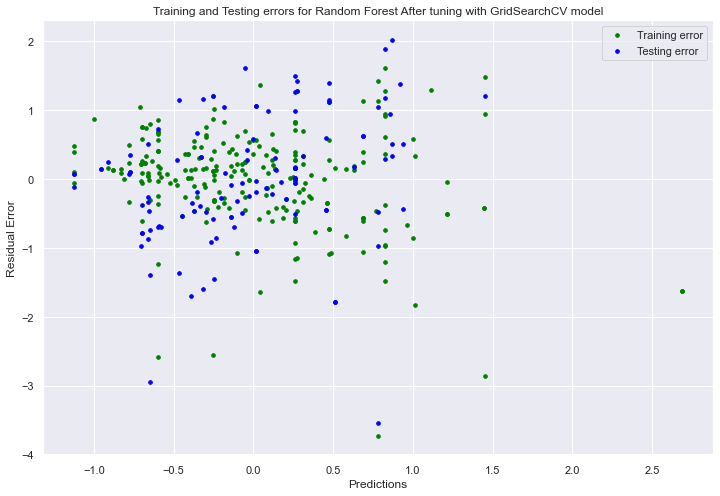

In [134]:
model_best_RF = RandomForestRegressor(n_estimators = 100, bootstrap =True,max_depth = 7,max_features ='sqrt', random_state = 18).fit(X_train, Y_train)
Y_pred, rmse_RF_best = testing_metrics(X_test,Y_test,model_best_RF)
Y_predict_2 ,rmse_RF_best_train= training_metrics(Y_train,X_train,model_best_RF)
plot_errors(Y_pred,Y_predict_2,Y_test,Y_train,'Random Forest After tuning with GridSearchCV')

In [135]:
# Save the modle using pickle 
import pickle

with open('final_model.pickle', 'wb') as f:
    pickle.dump(model_best_RF, f)

In [136]:

from sklearn.tree import DecisionTreeRegressor 
simple_decision = DecisionTreeRegressor(criterion = 'squared_error',max_depth=3,random_state = 0) 
simple_decision.fit(X_train, Y_train)
Y_pred, rmse_DT = testing_metrics(X_test,Y_test,simple_decision )
Y_predict_2 ,rmse_DT_train= training_metrics(Y_train,X_train,simple_decision )




Testing data Results

Mean squared error (MSE):  0.92
Root Mean squared error (RMSE): 0.96
Training data Results

Mean squared error (MSE) :  0.83
Root Mean squared error (RMSE): 0.91


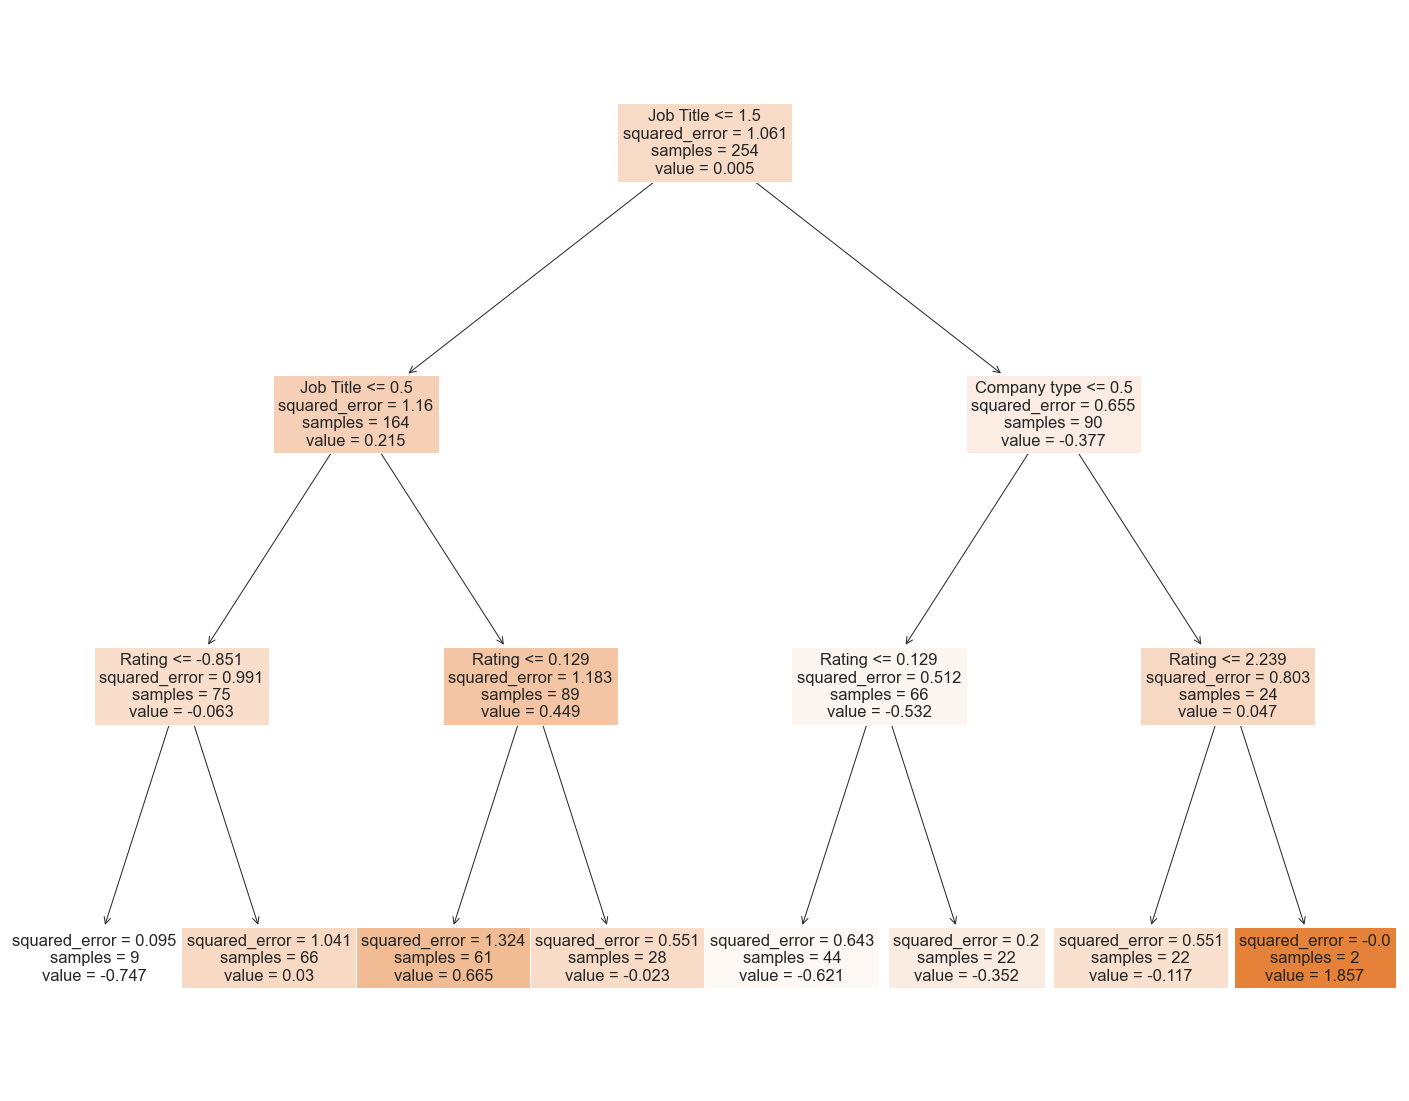

In [137]:
names = ['Job Title','Location','Rating','Company type']
text_representation = tree.export_text(simple_decision)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(simple_decision, feature_names=names, filled=True)

### Using Boosting Method: AdaBoost Regressor

In [138]:
grid = { 
    'n_estimators': [10,20,40,60],
     'learning_rate': [0.5,1,1.5,2],
    'loss' : ['linear', 'square'],
    'random_state' : [18]
}
## show start time

## Grid Search function
CV_adab = GridSearchCV(estimator=AdaBoostRegressor(), param_grid=grid, cv= 5)
CV_adab.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [0.5, 1, 1.5, 2],
                         'loss': ['linear', 'square'],
                         'n_estimators': [10, 20, 40, 60],
                         'random_state': [18]})

In [139]:
CV_adab.best_params_

{'learning_rate': 1, 'loss': 'linear', 'n_estimators': 40, 'random_state': 18}

Testing data Results

Mean squared error (MSE):  1.09
Root Mean squared error (RMSE): 1.04
Training data Results

Mean squared error (MSE) :  0.94
Root Mean squared error (RMSE): 0.97


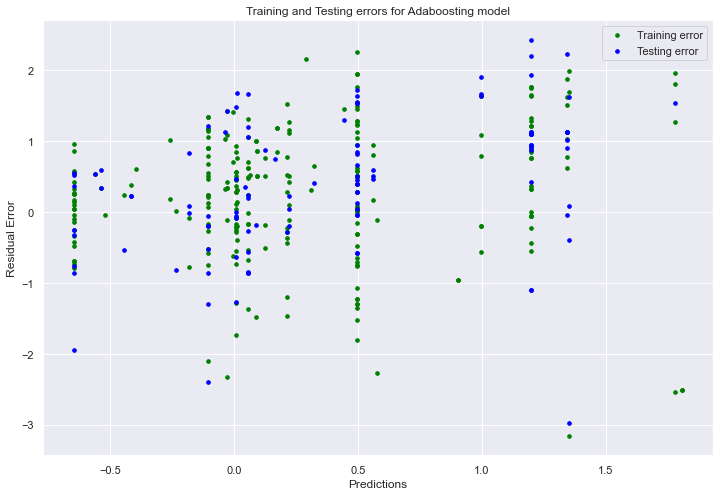

In [140]:
ada_model = AdaBoostRegressor(n_estimators = 40,learning_rate =1,loss = 'linear', random_state = 18).fit(X_train, Y_train)
Y_pred = ada_model.predict(X_test)
Y_pred, rmse_ada = testing_metrics(X_test,Y_test,ada_model)
Y_predict_2,rmse_ada_train = training_metrics(Y_train,X_train,ada_model)
plot_errors(Y_pred,Y_predict_2,Y_test,Y_train,'Adaboosting')

### KNN Model

In [141]:
## KNN model has hyperparmater 'k', lets find out :
rmse_val=[]
rmse_val_2=[]
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, Y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(Y_test,pred))
    pred_2=model.predict(X_train)
    error_2 = sqrt(mean_squared_error(Y_train,pred_2))#calculate rmse
    rmse_val.append(error) #store rmse values
    rmse_val_2.append(error_2)

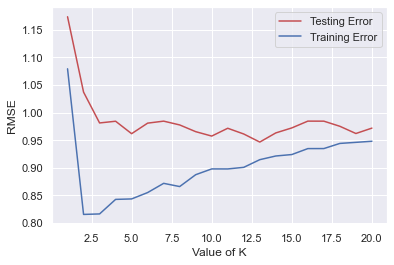

In [142]:
x_range =np.arange(1,21,1)
plt.plot(x_range,rmse_val,'r')
plt.plot(x_range,rmse_val_2,'b')
plt.legend(['Testing Error','Training Error'])
plt.xlabel('Value of K')
plt.ylabel('RMSE')
plt.show()

In [143]:
# lets go with k=10
knn_model = neighbors.KNeighborsRegressor(n_neighbors = 10)
knn_model.fit(X_train, Y_train)  #fit the model
Y_pred, rmse_knn = testing_metrics(X_test,Y_test,knn_model)
Y_predict_2,rmse_knn_train = training_metrics(Y_train,X_train,knn_model)
# plot_errors(Y_pred,Y_predict_2,Y_test,Y_train,'KNN')

Testing data Results

Mean squared error (MSE):  0.92
Root Mean squared error (RMSE): 0.96
Training data Results

Mean squared error (MSE) :  0.81
Root Mean squared error (RMSE): 0.90


### SVM Regressor

In [144]:
grid = { 
    'kernel': ['rbf','linear','poly']
}
## show start time

## Grid Search function
CV_SVR = GridSearchCV(estimator=SVR(), param_grid=grid, cv= 5)
CV_SVR.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'kernel': ['rbf', 'linear', 'poly']})

In [145]:
CV_SVR.best_params_

{'kernel': 'rbf'}

Testing data Results

Mean squared error (MSE):  0.86
Root Mean squared error (RMSE): 0.92
Training data Results

Mean squared error (MSE) :  0.87
Root Mean squared error (RMSE): 0.93


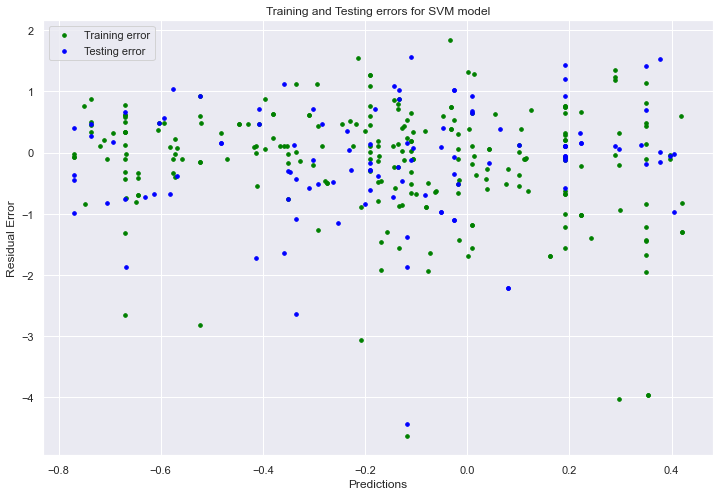

In [146]:
svm_model = SVR(kernel ='rbf').fit(X_train, Y_train)
Y_pred = svm_model.predict(X_test)
Y_pred, rmse_svm = testing_metrics(X_test,Y_test,svm_model)
Y_predict_2,rmse_svm_train = training_metrics(Y_train,X_train,svm_model)
plot_errors(Y_pred,Y_predict_2,Y_test,Y_train,'SVM')

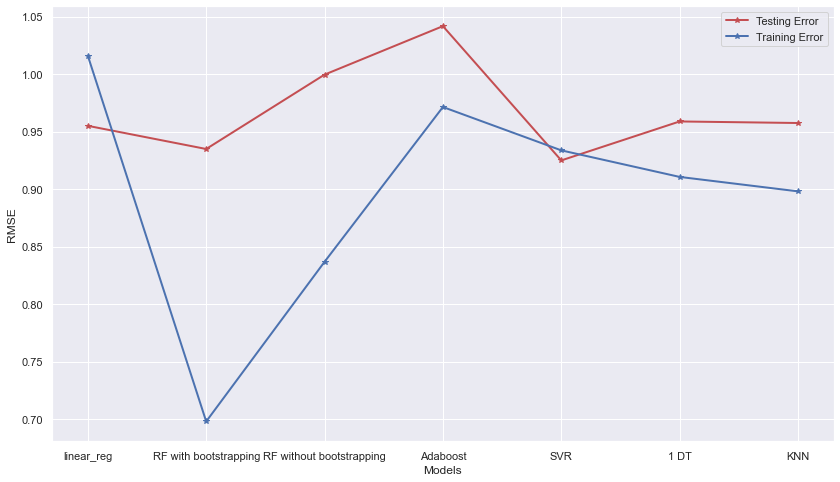

In [147]:
## Comparisons of different model:
models = ['linear_reg','RF with bootstrapping','RF without bootstrapping','Adaboost','SVR','1 DT','KNN']
rmse_value = [rmse_reg,rmse_RF_best,rmse_RF_without_bootstrap,rmse_ada,rmse_svm,rmse_DT,rmse_knn]
rmse_value_train = [rmse_reg_train,rmse_RF_best_train,rmse_RF_without_bootstrap_train,rmse_ada_train,rmse_svm_train,rmse_DT_train,rmse_knn_train]
plt.figure(figsize=(14,8))
plt.plot(models,rmse_value,'r',linewidth=2, marker ='*')
plt.plot(models,rmse_value_train,'b',linewidth=2, marker ='*')
plt.legend(['Testing Error'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.legend(['Testing Error','Training Error'])
plt.show()

In [148]:
# st_x.inverse_transform(Y_pred.reshape(-1,1))